In [ ]:
# for cloud version
!pip install pandas matplotlib dwave-ocean-sdk

In [33]:
from typing import Optional
from time import ctime

import matplotlib.pyplot as plt
import pandas as pd

import dimod
from dwave.samplers import TabuSampler

from utils import Mapping, get_attacks_for_each_cell, get_pos_mapping

In [8]:
def get_qubo(mapping:Mapping, n:int) -> dimod.BinaryQuadraticModel:
    """
    params:
        mapping : Mapping - the mapping of board positions to numeric variables
        n : int - the board side

    Map the NQueens problem into qubo.
    """

    model = dimod.BinaryQuadraticModel(vartype='BINARY')

    for i in range(n):
        for j in range(n):

            """
            For each cell, we gonna get all possible attacks and then add
            the variables relations based on the attacks.
            """

            pos = (i,j)
            current_pos_map = mapping[pos]
            attacks = get_attacks_for_each_cell(pos, n)

            for attack in attacks:
                
                """
                The quadratic terms are just the current cell multipled by
                the attack cell. At the end, everyone of these must result to zero.
                """

                mapped_pos = mapping[attack]
                model.add_quadratic(f'x{mapped_pos}', f'x{current_pos_map}', 1)

    # As constraint, we must ensure that only N queens are placed in the board.
    constraint_total_vars = [(f'x{i}',1) for i in mapping.values()]
    model.add_linear_equality_constraint(constraint_total_vars, n*n, -n)

    return model

             

In [6]:
N = 4
mapping = get_pos_mapping(N)

In [9]:
qubo = get_qubo(mapping, N)

In [11]:
def get_result_min_energy(data:pd.DataFrame) -> pd.DataFrame:
    """
    params:
        data : pd.DataFrame - the sampleset as DataFrame

    Get the sample result and filter to get only the minimun energy
    of the system (the solution).
    """
    return data[data['energy'] == data['energy'].min()]

In [19]:
def plot_solution(mapping:Mapping, row:pd.Series, title:Optional[str]=None):
    """
    params:
        mapping : Mapping - the board mapping to binary variables
        row : pd.Series - the solution row from the pandas Dataframe
        title : Optional[str] - the title of the plot (default is None) 

    Plot the matrix representation of the solution found.
    """

    matrix = [[0]*N for i in range(N)]

    for i in range(N):
        for j in range(N):
            mapped_pos = mapping[(i,j)]
            matrix[i][j] = row[f'x{mapped_pos}']

    plt.pcolormesh(matrix,edgecolors="k",linewidth=2)
    plt.axis('off')

    if(title):
        plt.title(title)

    plt.savefig("%s.png"%(title if title else ctime()), bbox_inches="tight")

    plt.show()

# Exact solver

In [37]:
sampler = dimod.ExactSolver()
sampleset = sampler.sample(qubo)

In [38]:
df = sampleset.to_pandas_dataframe()
df.to_csv("qubo-exact-solver-solution.csv")
best_solutions = get_result_min_energy(df)
best_solutions

,x0,x1,x10,x11,x12,x13,x14,x15,x2,x3,x4,x5,x6,x7,x8,x9,energy,num_occurrences
12296,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0.0,1
32798,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0.0,1


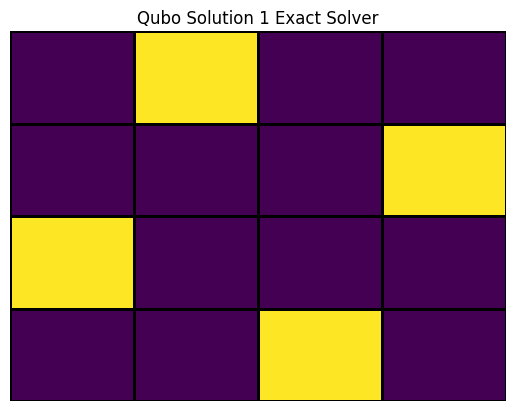

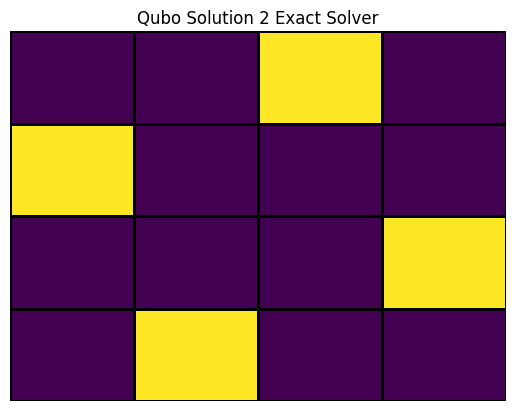

In [39]:
for solution_i in range(len(best_solutions)):
    row = best_solutions.iloc[solution_i]
    plot_solution(mapping, row, "Qubo Solution %d Exact Solver"%(solution_i+1))

# Tabu Search

In [40]:
sampler = TabuSampler()

In [41]:
sampleset = sampler.sample(qubo, tenure=N, num_restarts=N)

In [42]:
df = sampleset.to_pandas_dataframe()
df.to_csv("qubo-tabu-search-solution.csv")
best_solutions = get_result_min_energy(df)
best_solutions

,x0,x1,x10,x11,x12,x13,x14,x15,x2,x3,x4,x5,x6,x7,x8,x9,energy,num_occurrences,num_restarts
0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0.0,1,1


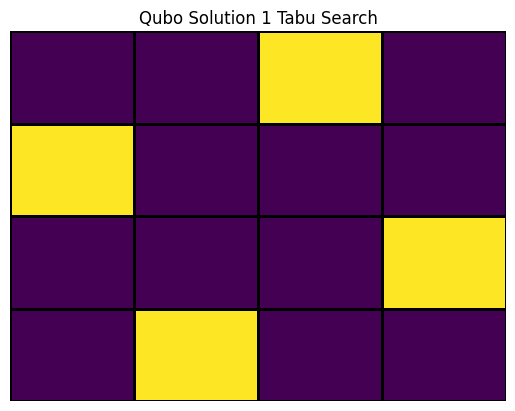

In [43]:
for solution_i in range(len(best_solutions)):
    row = best_solutions.iloc[solution_i]
    plot_solution(mapping, row, "Qubo Solution %d Tabu Search"%(solution_i+1))